In [1]:
%reset -f

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
import os
import torchvision
from torchvision.io.image import ImageReadMode
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader, random_split
import tqdm
from typing import Callable, Any
from enum import Enum
import math
import json
from datetime import datetime

torch.cuda.empty_cache()

In [2]:
class DenoiserDataset(Dataset):
    def __init__(self, data:torch.Tensor):
        self.data:torch.Tensor = data

    def __len__(self) -> int:
        return self.data.shape[0]

    def __getitem__(self, idx:int) -> torch.Tensor:
        return self.data[idx]

def load_dataset() -> DenoiserDataset:
    images_dir:str = os.path.join(os.getcwd(), "Dataset", "128x128")
    images_path:list[str] = os.listdir(images_dir)
    images:list[torch.Tensor] = list[torch.Tensor]()

    for image_local_path in images_path:
        image_absolute_path:str = os.path.join(images_dir, image_local_path)
        image:torch.Tensor = torchvision.io.read_image(image_absolute_path, ImageReadMode.RGB).type(torch.float32) / 255.0
        image = image * 2.0 - 1.0 # Extend the image for the [-1, 1] range
        images.append(image)
    return DenoiserDataset(torch.stack(images).cpu())

dataset:DenoiserDataset = load_dataset()

In [3]:
def plot_dataset_image(nb_image:int) -> None:
    for _ in range(0, nb_image):
        index:int = random.randint(0, len(dataset) - 1)
        image:torch.Tensor = dataset[index] * 0.5 + 0.5
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.show()
        
# plot_dataset_image(1)

In [ ]:
class BetaSchedulerType(Enum):
    linear = 1
    cosine = 2

class UNetSetting:
    def __init__(self, in_channels:int, base_channels:int, time_emb_dim:int, attention_resolutions:list[int]) -> None:
        self.in_channels:int = in_channels
        self.base_channels:int = base_channels
        self.time_emb_dim:int = time_emb_dim
        self.attention_resolutions:list[int] = attention_resolutions

#constant
image_size:int = dataset[0].shape[1]

# Model hyperparameters
beta_scheduler_start:float = 1e-4
beta_scheduler_end:float = 0.02

#training params
in_channels:int = 3
base_channels:int = 96
time_emb_dim:int = 512
attention_resolutions:list[int] = [64, 32, 16, 8]
unet_setting = UNetSetting(in_channels, base_channels, time_emb_dim, attention_resolutions)
beta_schedule_type:BetaSchedulerType = BetaSchedulerType.linear
batch_size:int = 8
timestep:int = 1000
ema_decay:float = 0.9999
use_EMA:bool = False
epochs:int = 3000
test_proportion:float = 0.1

total_steps:int = epochs * (int(len(dataset) * (1.0 - test_proportion)) // batch_size)
base_lr:float = 2e-4
def lr_scheduler_fn(step:int) -> float:
    return base_lr

lr_scheduler:Callable[[int], float] = lr_scheduler_fn

# To plot lr curve, uncomment the line below
# X:list[float] = [float(i) for i in range(0, total_steps)]
# Y:list[float] = [lr_scheduler_fn(i) for i in range(0, total_steps )]
# plt.plot(X, Y)
# plt.show()

saving_epoch_interval:int = 25
print_epoch_interval:int = 25
nb_sample_to_print:int = 1
device:str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device : {device}")

Device : cpu


In [5]:
def sinusoidal_embedding(timesteps:torch.Tensor, dim:int) -> torch.Tensor:
    """
    Create sinusoidal embeddings for timesteps.
    timesteps: (B,) tensor of integers
    dim: embedding dimension
    """
    device:str = str(timesteps.device)
    half_dim:int = dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb  # shape (B, dim)

class AttentionBlock(nn.Module):
    def __init__(self, channels:int, num_heads:int=4):
        super().__init__()
        self.num_heads:int = num_heads
        self.norm:nn.GroupNorm = nn.GroupNorm(8, channels)
        self.qkv:nn.Conv2d = nn.Conv2d(channels, channels * 3, 1)
        self.proj:nn.Conv2d = nn.Conv2d(channels, channels, 1)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        B:int = 0
        C:int = 0
        H:int = 0
        W:int = 0
        B, C, H, W = x.shape
        qkv:torch.Tensor = self.qkv(self.norm(x))

        chunks:tuple[torch.Tensor, ...] = qkv.chunk(3, dim=1)
        q:torch.Tensor = chunks[0]
        k:torch.Tensor = chunks[1]
        v:torch.Tensor = chunks[2]
        
        q = q.reshape(B, self.num_heads, C // self.num_heads, H * W)
        k = k.reshape(B, self.num_heads, C // self.num_heads, H * W)
        v = v.reshape(B, self.num_heads, C // self.num_heads, H * W)
        
        attn:torch.Tensor = torch.einsum('bhcd,bhce->bhde', q, k) / math.sqrt(C // self.num_heads)
        attn = F.softmax(attn, dim=-1)
        
        out:torch.Tensor = torch.einsum('bhde,bhce->bhcd', attn, v)
        out = out.reshape(B, C, H, W)
        return x + self.proj(out)

class ResBlock(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, time_emb_dim:int, dropout:float=0.1):
        super().__init__()
        self.norm1:nn.GroupNorm = nn.GroupNorm(8, in_channels)
        self.act1:nn.SiLU = nn.SiLU()
        self.conv1:nn.Conv2d = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        
        self.time_mlp:nn.Sequential = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        
        self.norm2:nn.GroupNorm = nn.GroupNorm(8, out_channels)
        self.act2:nn.SiLU = nn.SiLU()
        self.dropout:nn.Dropout = nn.Dropout(dropout)
        self.conv2:nn.Conv2d = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        self.res_conv:nn.Module = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        
    def forward(self, x:torch.Tensor, t_emb:torch.Tensor) -> torch.Tensor:
        h:torch.Tensor = self.norm1(x)
        h = self.act1(h)
        h = self.conv1(h)

        t_emb = self.time_mlp(t_emb)[:, :, None, None]
        h = h + t_emb
        h = self.norm2(h)
        h = self.act2(h)
        h = self.dropout(h)
        h = self.conv2(h)
        return h + self.res_conv(x)

#V0.3
class UNet(nn.Module):
    def __init__(self, in_channels:int, base_channels:int, time_emb_dim:int, attention_resolutions:list[int]):
        super().__init__()

        self.time_emb_dim:int = time_emb_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)

        self.down1 = nn.ModuleList([
            ResBlock(base_channels, base_channels, time_emb_dim),
            AttentionBlock(base_channels) if 128 in attention_resolutions else nn.Identity(),
            ResBlock(base_channels, base_channels, time_emb_dim),
            AttentionBlock(base_channels) if 128 in attention_resolutions else nn.Identity(),
        ])
        self.downsample1 = nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1)

        self.down2 = nn.ModuleList([
            ResBlock(base_channels * 2, base_channels * 2, time_emb_dim),
            AttentionBlock(base_channels * 2) if 64 in attention_resolutions else nn.Identity(),
            ResBlock(base_channels * 2, base_channels * 2, time_emb_dim),
            AttentionBlock(base_channels * 2) if 64 in attention_resolutions else nn.Identity(),
        ])
        self.downsample2 = nn.Conv2d(base_channels * 2, base_channels * 4, 4, 2, 1)

        self.down3 = nn.ModuleList([
            ResBlock(base_channels * 4, base_channels * 4, time_emb_dim),
            AttentionBlock(base_channels * 4) if 32 in attention_resolutions else nn.Identity(),
            ResBlock(base_channels * 4, base_channels * 4, time_emb_dim),
            AttentionBlock(base_channels * 4) if 32 in attention_resolutions else nn.Identity(),
        ])
        self.downsample3 = nn.Conv2d(base_channels * 4, base_channels * 8, 4, 2, 1)

        self.down4 = nn.ModuleList([
            ResBlock(base_channels * 8, base_channels * 8, time_emb_dim),
            AttentionBlock(base_channels * 8) if 16 in attention_resolutions else nn.Identity(),
            ResBlock(base_channels * 8, base_channels * 8, time_emb_dim),
            AttentionBlock(base_channels * 8) if 16 in attention_resolutions else nn.Identity(),
        ])
        self.downsample4 = nn.Conv2d(base_channels * 8, base_channels * 16, 4, 2, 1)

        self.mid1 = ResBlock(base_channels * 16, base_channels * 16, time_emb_dim)
        self.mid_attn = AttentionBlock(base_channels * 16) if 8 in attention_resolutions else nn.Identity()
        self.mid2 = ResBlock(base_channels * 16, base_channels * 16, time_emb_dim)

        self.upsample1 = nn.ConvTranspose2d(base_channels * 16, base_channels * 8, 4, 2, 1)
        self.up1 = nn.ModuleList([
            ResBlock(base_channels * 16, base_channels * 8, time_emb_dim),
            AttentionBlock(base_channels * 8) if 16 in attention_resolutions else nn.Identity(),
            ResBlock(base_channels * 8, base_channels * 8, time_emb_dim),
            AttentionBlock(base_channels * 8) if 16 in attention_resolutions else nn.Identity(),
        ])

        self.upsample2 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 4, 2, 1)
        self.up2 = nn.ModuleList([
            ResBlock(base_channels * 8, base_channels * 4, time_emb_dim),
            AttentionBlock(base_channels * 4) if 32 in attention_resolutions else nn.Identity(),
            ResBlock(base_channels * 4, base_channels * 4, time_emb_dim),
            AttentionBlock(base_channels * 4) if 32 in attention_resolutions else nn.Identity(),
        ])

        self.upsample3 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, 2, 1)
        self.up3 = nn.ModuleList([
            ResBlock(base_channels * 4, base_channels * 2, time_emb_dim),
            AttentionBlock(base_channels * 2) if 64 in attention_resolutions else nn.Identity(),
            ResBlock(base_channels * 2, base_channels * 2, time_emb_dim),
            AttentionBlock(base_channels * 2) if 64 in attention_resolutions else nn.Identity(),
        ])

        self.upsample4 = nn.ConvTranspose2d(base_channels * 2, base_channels, 4, 2, 1)
        self.up4 = nn.ModuleList([
            ResBlock(base_channels * 2, base_channels, time_emb_dim),
            AttentionBlock(base_channels) if 128 in attention_resolutions else nn.Identity(),
            ResBlock(base_channels, base_channels, time_emb_dim),
            AttentionBlock(base_channels) if 128 in attention_resolutions else nn.Identity(),
        ])

        self.norm_out = nn.GroupNorm(8, base_channels)
        self.act_out = nn.SiLU()
        self.conv_out = nn.Conv2d(base_channels, in_channels, 3, padding=1)

    # x.shape = (batch_size, 3, image_size, image_size)
    # t.shape = (batch_size), dtype=long
    def forward(self, x:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        t_emb:torch.Tensor = sinusoidal_embedding(t.long(), self.time_emb_dim)
        t_emb = self.time_mlp(t_emb)

        h1:torch.Tensor = self.conv_in(x)
        for block in self.down1: 
            h1 = block(h1, t_emb)  if isinstance(block, ResBlock) else block(h1)
        h2:torch.Tensor = self.downsample1(h1)

        for block in self.down2: 
            h2 = block(h2, t_emb) if isinstance(block, ResBlock) else block(h2)
        h3:torch.Tensor = self.downsample2(h2)

        for block in self.down3:
            h3 = block(h3, t_emb) if isinstance(block, ResBlock) else block(h3)
        h4:torch.Tensor = self.downsample3(h3)
        
        for block in self.down4:
            h4 = block(h4, t_emb) if isinstance(block, ResBlock) else block(h4)
        h5:torch.Tensor = self.downsample4(h4)

        h:torch.Tensor = self.mid1(h5, t_emb)
        h = self.mid_attn(h)
        h = self.mid2(h, t_emb)

        h = self.upsample1(h)
        h = torch.cat([h, h4], dim=1)
        for block in self.up1:
            h = block(h, t_emb) if isinstance(block, ResBlock) else block(h)

        h = self.upsample2(h)
        h = torch.cat([h, h3], dim=1)
        for block in self.up2:
            h = block(h, t_emb) if isinstance(block, ResBlock) else block(h)

        h = self.upsample3(h)
        h = torch.cat([h, h2], dim=1)
        for block in self.up3:
            h = block(h, t_emb) if isinstance(block, ResBlock) else block(h)

        h = self.upsample4(h)
        h = torch.cat([h, h1], dim=1)
        for block in self.up4:
            h = block(h, t_emb) if isinstance(block, ResBlock) else block(h)

        h = self.norm_out(h)
        h = self.act_out(h)
        return self.conv_out(h)

In [6]:
class DiffusionModel:
    def __init__(self, model:UNet, optimizer:torch.optim.Optimizer | None, criterion:_Loss | None, beta_schedule_type:BetaSchedulerType, timesteps:int, device:str) -> None:
        self.model:UNet = model.to(device)
        self.optimizer:torch.optim.Optimizer| None = optimizer
        self.criterion:_Loss| None = criterion
        self.timesteps:int = timesteps
        self.device:str = device
        
        if beta_schedule_type == BetaSchedulerType.linear:
            self.beta:torch.Tensor = torch.linspace(beta_scheduler_start, beta_scheduler_end, self.timesteps)
            self.alpha:torch.Tensor = 1.0 - self.beta
            self.alpha_bar:torch.Tensor = torch.cumprod(self.alpha, dim=0)
            alpha_bar_prev:torch.Tensor = torch.cat([torch.tensor([1.0]), self.alpha_bar[:-1]])
            self.posterior_variance:torch.Tensor = self.beta * ((1 - alpha_bar_prev) / (1 - self.alpha_bar))
        else: # beta_schedule_type == BetaSchedulerType.cosine
            s:float = 0.008
            x:torch.Tensor = torch.linspace(0, self.timesteps, self.timesteps + 1)
            self.alpha_bar:torch.Tensor = torch.cos(((x / self.timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
            self.alpha_bar = self.alpha_bar / self.alpha_bar[0]
            self.beta:torch.Tensor = 1.0 - (self.alpha_bar[1:] / self.alpha_bar[:-1])
            self.beta = torch.clamp(self.beta, 1e-5, 0.999)
            self.alpha = 1.0 - self.beta
            alpha_bar_prev:torch.Tensor = torch.cat([torch.tensor([1.0]), self.alpha_bar[:-1]])
            self.posterior_variance:torch.Tensor = self.beta * ((1 - alpha_bar_prev) / (1 - self.alpha_bar))

    #x0.shape : (batch_size, in_channels, base_channels, base_channels)
    #t.shape : (batch_size,)
    def _add_noise(self, x0:torch.Tensor, t:torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        with torch.no_grad():
            noise:torch.Tensor = torch.randn(x0.shape)
            alpha_bar_t:torch.Tensor = self.alpha_bar[t].view(-1, 1, 1, 1) # this line is ok
            noisy_image:torch.Tensor = (torch.sqrt(alpha_bar_t) * x0) + (torch.sqrt(1 - alpha_bar_t) * noise)
            return noisy_image.to(self.device), noise.to(self.device)
        
    # x0 are the clean images of shape [batch_size, in_channels, base_channels, base_channels] on the CPU
    # return the loss, the noisy x0, the predicted noise and the noise apply to x0
    # loss is use for training, the rest for debugging purpose
    def train_step(self, x0:torch.Tensor) -> tuple[float, torch.Tensor, torch.Tensor, torch.Tensor]:
        if self.optimizer == None or self.criterion == None:
            return (0.0, torch.empty((0,)), torch.empty((0,)), torch.empty((0,)))

        self.optimizer.zero_grad()

        t:torch.Tensor = torch.randint(0, self.timesteps, (x0.shape[0],), dtype=torch.long)
        xt, noise = self._add_noise(x0, t)
        xt_detach:torch.Tensor = xt.detach().cpu().clone()
        noise_detach:torch.Tensor = noise.detach().cpu().clone()
        t = t.to(self.device)

        pred_noise:torch.Tensor = self.model(xt, t)
        pred_noise_detach:torch.Tensor = pred_noise.detach().cpu().clone()
        loss:torch.Tensor = self.criterion(pred_noise, noise)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        return loss.cpu().item(), xt_detach, pred_noise_detach, noise_detach
    
    def sample(self, nb_sample:int, verbose:bool=False) -> torch.Tensor:
        with torch.no_grad():
            x:torch.Tensor = torch.randn((nb_sample, in_channels, image_size, image_size), device=self.device)

            if verbose:
                image:torch.Tensor = torch.clamp(x[0].detach().cpu() * 0.5 + 0.5, 0.0, 1.0)
                plt.imshow(image.permute(1, 2, 0))
                plt.show()

            for i, t in enumerate(reversed(range(0, self.timesteps))):
                t_tensor:torch.Tensor = torch.full((nb_sample,), t, device=self.device, dtype=torch.long)
                pred_noise:torch.Tensor = self.model(x, t_tensor)
                alpha_t:torch.Tensor = self.alpha[t].to(self.device)
                alpha_bar_t:torch.Tensor = self.alpha_bar[t].to(self.device)

                coeff1:torch.Tensor = (1.0 / torch.sqrt(alpha_t))
                coeff2:torch.Tensor = ((1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t))
                x =  coeff1 * (x - (coeff2 * pred_noise))

                if t > 0:
                    # DDIM-style variance interpolation, may be better than posterior_variance
                    # sigma_t:torch.Tensor = torch.sqrt(0.5 * self.posterior_variance[t] + (0.5 * self.beta[t]))
                    sigma_t:torch.Tensor = torch.sqrt(self.posterior_variance[t])
                    x += sigma_t * torch.randn_like(x)

                if verbose and i % (self.timesteps // 10) == 0:
                    image:torch.Tensor = torch.clamp(x[0].detach().cpu() * 0.5 + 0.5, 0.0, 1.0)
                    plt.imshow(image.permute(1, 2, 0))
                    plt.show()
                    
            return torch.clamp(x * 0.5 + 0.5, 0.0, 1.0).cpu()

In [7]:
class EMA:
    def __init__(self, model:UNet, decay:float):
        self.decay:float = decay
        self.ema_model:dict[str, Any] = {k: v.clone() for k, v in model.state_dict().items()}

    def update(self, model:UNet) -> None:
        with torch.no_grad():
            for k, v in model.state_dict().items():
                self.ema_model[k] -= (1.0 - self.decay) * (self.ema_model[k] - v)

    def state_dict(self) -> dict[str, Any]:
        return self.ema_model

    def load_state_dict(self, state_dict) -> None:
        self.ema_model = state_dict

In [8]:
def load_denoiser(file:str) -> UNet:
    model:UNet = UNet(unet_setting.in_channels, unet_setting.base_channels, unet_setting.time_emb_dim, unet_setting.attention_resolutions)
    model_path:str = os.path.join(os.getcwd(), "Models", file)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    return model

# denoiser = load_denoiser("best_denoiser_02_linear.model")

# param_size = 0
# for param in denoiser.parameters():
#     param_size += param.nelement() * param.element_size()

# size_all_mb = (param_size + 0) / (1024**2)
# print("Model size: {:.3f} MB with {} parameters".format(size_all_mb, sum(p.numel() for p in denoiser.parameters())))

In [9]:
class TrainResult:
    train_losses:list[float]
    test_losses:list[float]

    @staticmethod
    def from_json(json_str:str) -> 'TrainResult':
        d = json.loads(json_str)
        return TrainResult(**d)

    def __init__(self, train_losses:list[float], test_losses:list[float]) -> None:
        self.train_losses = train_losses
        self.test_losses = test_losses

    def to_json(self) -> str:
        return json.dumps(self.__dict__, indent=4)

Start training UNet


Training model:   0%|          | 226/678000 [21:41<1098:01:14,  5.83s/it]

Noisy image :


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.757684..2.4910429].


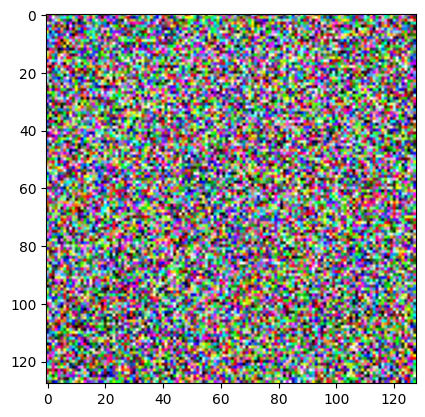

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41110277..1.1542263].


Predict noise :


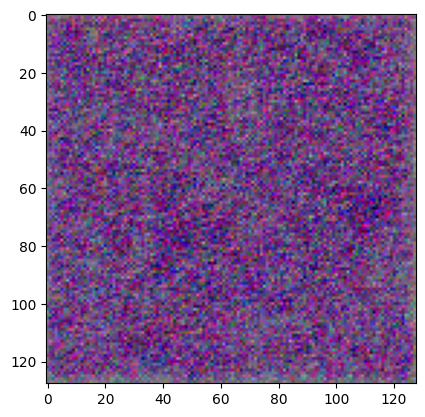

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7854702..2.4914556].


Added noise :


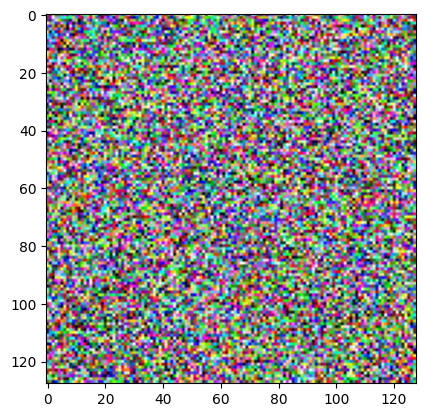

Training model:   0%|          | 226/678000 [21:53<1094:16:13,  5.81s/it]


KeyboardInterrupt: 

In [10]:
def train_denoiser(model:UNet, ema:EMA | None) -> TrainResult:
    return resume_train_denoiser(model, ema, 0)
    
def resume_train_denoiser(model:UNet, ema:EMA | None, epoch:int) -> TrainResult:

    sample_to_print = min(nb_sample_to_print, batch_size)
    epoch = max(0, epoch)

    train_result:TrainResult
    if epoch <= 0:
        train_result = TrainResult([], [])
    else:
        train_res_path:str = f"./Models/train_result_epoch{epoch}.txt"
        file = open(train_res_path, "r")
        string = file.read()
        train_result  = TrainResult.from_json(string)
        file.close()

    test_size:int = int(test_proportion * len(dataset))
    train_size:int = len(dataset) - test_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    optimizer:torch.optim.Adam = torch.optim.AdamW(model.parameters(), lr=lr_scheduler(0), weight_decay=1e-5) # use weight_decay=1e-4 if not use EMA
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_scheduler)

    criterion:nn.MSELoss = nn.MSELoss()
    diffusion:DiffusionModel = DiffusionModel(model, optimizer, criterion, beta_schedule_type, timestep, device)

    print("Start training UNet")
    with tqdm.tqdm(total=epochs * len(train_dataset), desc="Training model") as pbar:
        pbar.update(epoch * len(train_dataset))
        for epoch in range(epoch, epochs):
            train_loader:DataLoader = DataLoader(train_dataset, batch_size, shuffle=True)
            input_batch:torch.Tensor
            total_loss:float = 0.0

            last_noisy_images_batch:torch.Tensor = torch.zeros((0,))
            last_pred_noise_batch:torch.Tensor = torch.zeros((0,))
            last_noise_batch:torch.Tensor = torch.zeros((0,))
            for input_batch in train_loader:
                loss, noisy_images_batch, pred_noise_batch, noise_batch = diffusion.train_step(input_batch)
                if ema != None:
                    ema.update(model)

                last_noisy_images_batch = noisy_images_batch
                last_pred_noise_batch = pred_noise_batch
                last_noise_batch = noise_batch

                total_loss += loss

                pbar.update(input_batch.shape[0])

            print_sample:bool = print_epoch_interval > 0 and ((epoch + 1) % print_epoch_interval == 0 or epoch + 1 == epochs)
            if print_sample:
                for i in range(0, sample_to_print):
                    noisy_image:torch.Tensor = last_noisy_images_batch[i] * 0.5 + 0.5
                    pred_noise:torch.Tensor = last_pred_noise_batch[i] * 0.5 + 0.5
                    noise:torch.Tensor = last_noise_batch[i] * 0.5 + 0.5
                    print("Noisy image :")
                    plt.imshow(noisy_image.permute(1, 2, 0))
                    plt.show()
                    print("Predict noise :")
                    plt.imshow(pred_noise.permute(1, 2, 0))
                    plt.show()
                    print("Added noise :")
                    plt.imshow(noise.permute(1, 2, 0))
                    plt.show()

            train_loss:float = total_loss / (len(train_dataset) / batch_size)
            train_result.train_losses.append(train_loss)

            with torch.no_grad():
                total_loss = 0.0
                test_loader:DataLoader = DataLoader(test_dataset, batch_size, shuffle=True)
                for input_batch in test_loader:
                    loss, noisy_images_batch, pred_noise_batch, noise_batch = diffusion.train_step(input_batch)
                    total_loss += loss
                train_result.test_losses.append(total_loss / (len(test_dataset) / batch_size))

            save_epoch:bool = saving_epoch_interval >= 1 and ((epoch + 1) % saving_epoch_interval == 0 or epoch + 1 == epochs)
            if save_epoch:
                path:str = f"./Models/denoiser_epoch{epoch}.model" if epoch < epochs - 1 else "./Models/denoiser.model"
                if os.path.isfile(path):
                    os.remove(path)
                torch.save(model.state_dict(), path)

                if ema != None:
                    path:str = f"./Models/ema_denoiser_epoch{epoch}.model" if epoch < epochs - 1 else "./Models/ema_denoiser.model"
                    if os.path.isfile(path):
                        os.remove(path)
                    torch.save(ema.state_dict(), path)

                train_res_path:str = f"./Models/train_result_epoch{epoch}.txt" if epoch < epochs - 1 else "./Models/train_result.txt"
                file = open(train_res_path, "w")
                file.write(train_result.to_json())
                file.close()

                print(f"Denoiser Saved!")

        return train_result
    
denoiser:UNet = UNet(unet_setting.in_channels, unet_setting.base_channels, unet_setting.time_emb_dim, unet_setting.attention_resolutions)
ema:EMA | None = EMA(denoiser, ema_decay) if use_EMA else None
seed:int = 8476296554
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
train_result:TrainResult = train_denoiser(denoiser, ema)

# epoch_to_resume:int = 549
# denoiser:UNet = load_denoiser(f"denoiser_epoch{epoch_to_resume}.model")
# ema_model:UNet = load_denoiser(f"ema_denoiser_epoch{epoch_to_resume}.model")
# ema:EMA = EMA(ema_model, decay=ema_decay)
# train_result:TrainResult = resume_train_denoiser(denoiser, ema, epoch_to_resume)

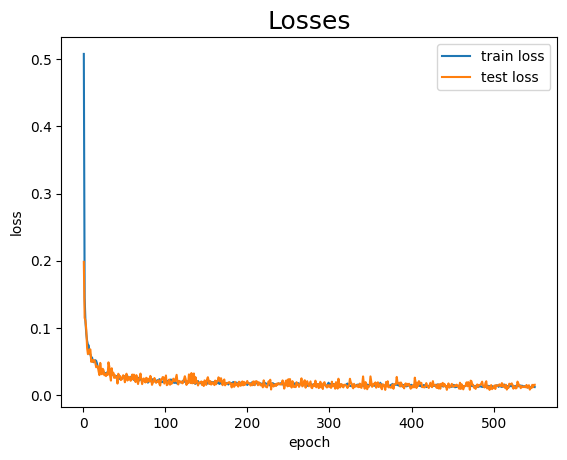

In [ ]:
def show_training_result(train_result:TrainResult) -> None:
    assert len(train_result.test_losses) == len(train_result.test_losses)
    X:list[float] = [float(i) for i in range(1, len(train_result.test_losses) + 1)]
    plt.plot(X, train_result.train_losses, label='train loss')
    plt.plot(X, train_result.test_losses, label='test loss')
    plt.title("Losses", fontsize=18)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

train_res_path:str = f"./Models/train_result_epoch{549}.txt"
file = open(train_res_path, "r")
train_result:TrainResult = TrainResult.from_json(file.read())
file.close()
show_training_result(train_result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6715674..3.5317998].


noisy image : 


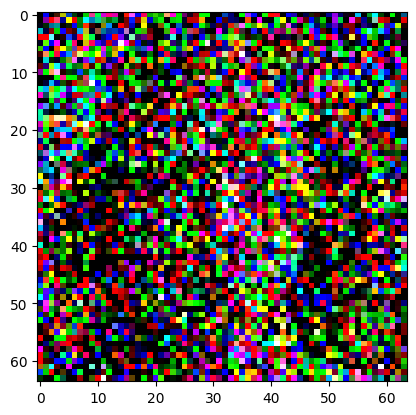

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7955263..3.9293325].


noise : 


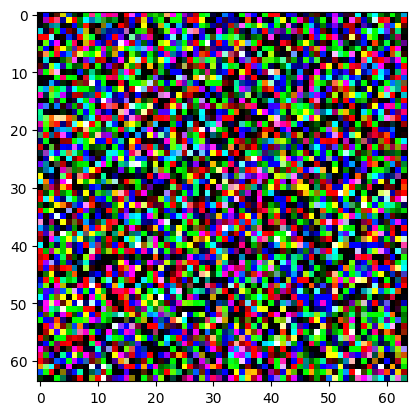

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.8813362..3.9797008].


predicted noise: 


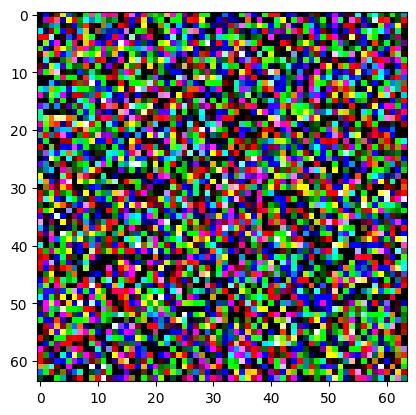

In [ ]:
def test_model(diffusion_model:DiffusionModel, test_size:int) -> None:
    with torch.no_grad():
        x0:torch.Tensor = torch.stack([dataset[random.randint(0, len(dataset) - 1)] for _ in range(0, test_size)])
        t:torch.Tensor = torch.randint(0, diffusion_model.timesteps, (test_size,))
        xt, noise = diffusion_model._add_noise(x0, t)
        t = t.float().to(diffusion_model.device)
        pred_noise:torch.Tensor = diffusion_model.model(xt, t)

        for i in range(0, test_size):
            print("noisy image : ")
            plt.imshow(xt[i].cpu().permute(1, 2, 0))
            plt.show()

            print("noise : ")
            plt.imshow(noise[i].cpu().permute(1, 2, 0))
            plt.show()

            print("predicted noise: ")
            plt.imshow(pred_noise[i].cpu().permute(1, 2, 0))
            plt.show()

denoiser:UNet = load_denoiser(f"denoiser_epoch{549}.model")
diffusion_model:DiffusionModel = DiffusionModel(denoiser, None, None, beta_schedule_type, timestep, device)
test_model(diffusion_model, 1)

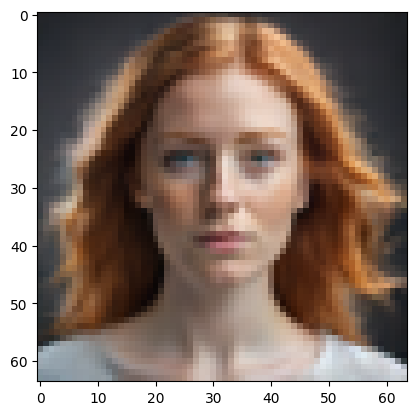

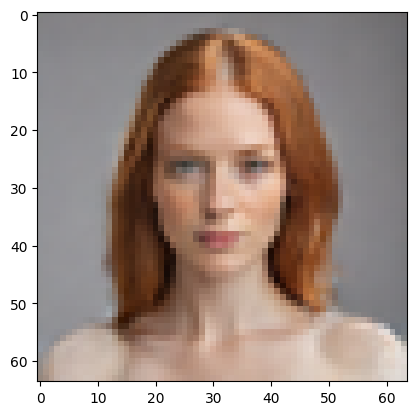

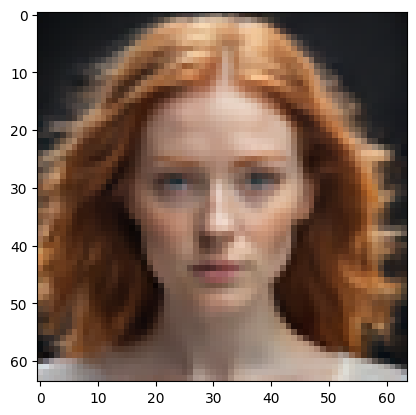

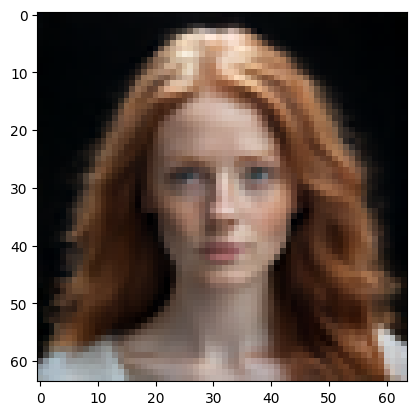

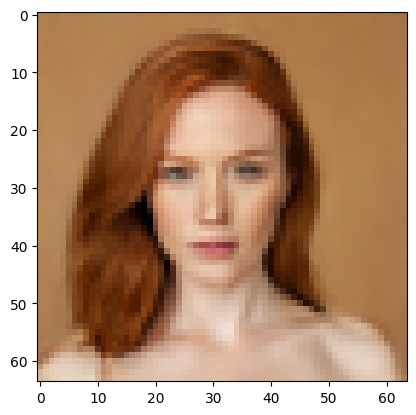

In [ ]:
denoiser_name:str = "best_model_02_linear.model"
img_prefix:str = "v0.2_linear"
denoiser:UNet = load_denoiser(denoiser_name)

diffusion_model:DiffusionModel = DiffusionModel(denoiser, None, None, beta_schedule_type, timestep, device)
samples:int = 10
images:torch.Tensor = diffusion_model.sample(samples, verbose=False)
for i in range(0, images.shape[0]):
    img:torch.Tensor = images[i].permute(1, 2, 0)
    plt.imshow(img)
    plt.show()

save_image:bool = False
if save_image:
    base_path:str = "./GeneratedImages"
    for i in range(0, images.shape[0]):
        now:datetime = datetime.now()
        local_path:str = f"{img_prefix}_{now.year}_{now.month}_{now.day}_{now.hour}_{now.minute}_{now.second}_{now.microsecond}_{denoiser_name}"
        img_path:str = os.path.join(base_path, f"{local_path}.png")
        torchvision.utils.save_image(images[i], img_path)